In [34]:
import pandas as pd
import numpy as np

In [35]:
train = pd.read_csv('train.csv', index_col = 0, parse_dates=[1])
test = pd.read_csv('test.csv', index_col = 0, parse_dates=[1])
train['sod']='train'
test['sod']='test'
print ("Train Dimensions:")
print (train.shape)
print ("Test Dimensions:")
print (test.shape)


Train Dimensions:
(137, 43)
Test Dimensions:
(100000, 42)


In [36]:
data = pd.concat((test, train), ignore_index=True)
print(data.shape)

(100137, 43)


In [37]:
# Convert date strings to "days open" numerical value
from matplotlib import pylab
%matplotlib inline
data['Open_Date']=data['Open Date'].apply(pd.to_datetime)
data=data.drop('Open Date',axis=1)


In [38]:
max_dt=max(data.Open_Date)
data['Days_since_opened']=(max_dt-data.Open_Date).dt.days
data=data.drop('Open_Date',axis=1)


In [39]:
ps=[i for i in data.columns if i.startswith('P')]

pd.set_option('display.max_columns', None)
train.loc[:,ps]
zeros=['P14','P15','P16','P17','P18','P24','P25','P26','P27',
      'P30','P31','P32','P33','P34','P35','P36','P37']


In [40]:
data['zeros']=(data[zeros]==0).sum(1)


In [41]:
data=data.drop('Days_since_opened',axis=1)


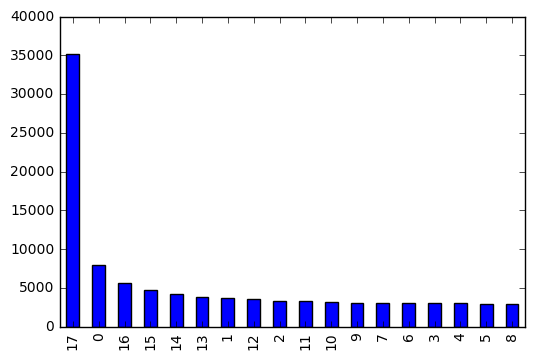

In [42]:
data.zeros.value_counts().plot(kind='bar')

In [43]:
data['City Group'].value_counts()

Other         50787
Big Cities    49350
Name: City Group, dtype: int64

In [44]:
data['Type'].value_counts()


FC    57095
IL    40507
DT     2245
MB      290
Name: Type, dtype: int64

In [45]:
data[data.Type=='DT'].Type='FC'
data[data.Type=='MB'].Type='IL'


/Users/priya/anaconda/lib/python3.5/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [46]:
data = data.join(pd.get_dummies(data['City Group'], prefix="CG"))
data = data.join(pd.get_dummies(data['Type'], prefix="T"))
data=data.drop(['City Group','Type'],axis=1)


In [47]:
data['City']=data.City.replace(data.City.value_counts())
data['Log_City']=data.City.apply(lambda x:np.log(x))
data=data.drop('City',axis=1)

In [48]:


# Now binarize the "P" columns with dummy variables
print ("Pre-binarizing columns:", len(data.columns))
for col in data.columns:
    if col[0] == 'P':
        data = data.join(pd.get_dummies(data[col], prefix=col))
        data = data.drop([col, data.columns[-1]], axis=1)
print ("Post-binarizing columns:", len(data.columns))



Pre-binarizing columns: 47
Post-binarizing columns: 283


In [54]:
train=data[data.sod=='train']
test=data[data.sod=='test']

train=train.drop('sod',axis=1)
test=test.drop('sod',axis=1)
y = train.revenue.apply(np.log)
X = train.drop(["revenue"], axis=1)
test=test.drop('revenue',axis=1)


In [65]:
from sklearn.linear_model import Ridge # only model used for final submission

from sklearn.cross_validation import LeaveOneOut
from sklearn.grid_search import (GridSearchCV, RandomizedSearchCV)
model_grid = [{'normalize': [True, False], 'alpha': np.logspace(0,10)}]
model = Ridge()

# Use a grid search and leave-one-out CV on the train set to find the best regularization parameter to use.
# (might take a minute or two)
grid = GridSearchCV(model, model_grid, cv=LeaveOneOut(len(y)), scoring='neg_mean_squared_error',verbose=1)
grid.fit(X, y)
print("Best parameters set found on development set:")
print(grid.best_params_)

# Re-train on full training set using the best parameters found in the last step.
model.set_params(**grid.best_params_)
model.fit(X, y)


/Users/priya/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/priya/anaconda/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Fitting 137 folds for each of 100 candidates, totalling 13700 fits
Best parameters set found on development set:
{'normalize': True, 'alpha': 4.0949150623804256}


[Parallel(n_jobs=1)]: Done 13700 out of 13700 | elapsed:   44.3s finished


Ridge(alpha=4.0949150623804256, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=True, random_state=None, solver='auto',
   tol=0.001)

In [66]:
submission = pd.DataFrame(columns=['Prediction'],index=test.index, data=model.predict(test))
submission.Prediction=submission.Prediction.apply(np.exp)
submission.index.name='Id'
# Write out the submission
submission.to_csv("TFI_Ridge.csv")
# Quick sanity check on the submission
submission.describe().astype(int)

Prediction
count      100000
mean      4058263
std        570737
min       2203107
25%       3678095
50%       4007172
75%       4360887
max       8573512

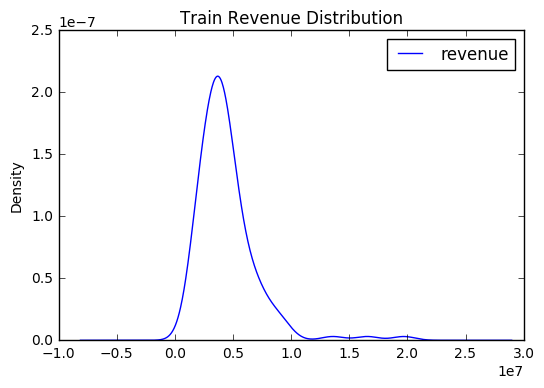

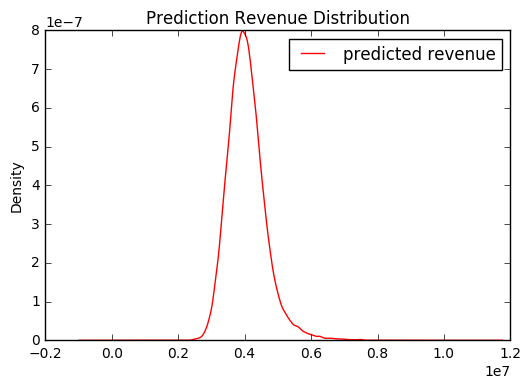

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline
train[['revenue']].plot(kind='kde', title="Train Revenue Distribution")
submission.columns = ["predicted revenue"]
submission.plot(kind='kde', title="Prediction Revenue Distribution", color='r')
plt.show()